# Mass Transports

Transport diagnostics for flow through major straits.


Formally, mass transports are given by
$$T_x = \rho u  $$
$$T_y = \rho v  $$

Mass transports are diagnostics that are calculated online by the model:

|variable|long name|units|dimensions|
|-|
|tx_trans|T-cell i-mass transport|Sv|(time,st_ocean,xu_ocean,yt_ocean)|
|ty_trans|T-cell j-mass transport|Sv|(time,st_ocean,xt_ocean,yu_ocean)|


These variables are saved in `ocean.nc` files averaged over three month periods.



In [1]:
%matplotlib inline

import cosima_cookbook as cc

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
import distributed
client = distributed.Client()

In [3]:
ty_trans = cc.get_nc_variable('GFDL50',
                              'ocean.nc',
                              'ty_trans', 
                              time_units = 'days since 2000',
                              )

In [4]:
ty = ty_trans.sum('st_ocean').sum('xt_ocean').sum('yu_ocean')

In [14]:
client

Client Scheduler: tcp://127.0.0.1:33016 Dashboard: http://127.0.0.1:8787,Cluster Workers: 8 Cores: 8 Memory: 20.20 GB


In [5]:
import distributed.diagnostics

In [12]:
futures = client.compute(ty.data)

In [13]:
distributed.diagnostics.progress(futures)

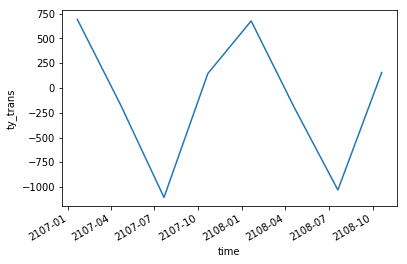

In [18]:
ty.plot()

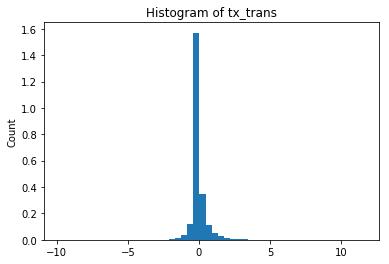

In [57]:
tx_trans_int_z.plot.hist(bins=np.ar);

What experiments have transport data saved?

At what temporal resolutions?

In [32]:
import sqlite3
conn = sqlite3.connect(cc.netcdf_index.database_file)
df = pd.read_sql("SELECT DISTINCT configuration, experiment, "
                 "       basename_pattern, "
                 "       count(run) "
                 "FROM ncfiles "
                 "WHERE variable LIKE 'tx_trans' "
                 "GROUP BY experiment", conn)
df

,configuration,experiment,basename_pattern,count(run)
0,access-om2-025,025deg_jra55_ryf_spinup1,ocean.nc,3
1,access-om2-025,025deg_jra55_ryf_spinup2,ocean.nc,51
2,access-om2-025,025deg_jra55_ryf_spinup3,ocean.nc,9
3,access-om2-025,025deg_jra55_ryf_spinup4,ocean.nc,3
4,access-om2,1deg_jra55_ryf_spinup1,None,10
5,access-om2,1deg_jra55_ryf_spinup2,None,100
6,mom01v5,GFDL50,ocean.nc,66
7,mom01v5,KDS75,ocean.nc,377
8,mom01v5,KDS75_PI,ocean.nc,120
9,mom01v5,KDS75_UP,ocean.nc,80


In [2]:
from __future__ import print_function

def page_printer(data, start=0, screen_lines=0, pager_cmd=None):
    if isinstance(data, dict):
        data = data['text/plain']
    print(data)

import IPython.core.page
IPython.core.page.page = page_printer

In [52]:
straights = { 'DrakePassage': [-69.9, -69.9, -71.6, -51.0],
              'Lombok':       [-244.6+360, -243.9+360, -8.6, -8.6],
              'Ombai' :       [-235.0+360, -235.0+360, -9.2, -8.1],
              'Timor' :       [-235.9+360, -235.9+360, -11.9, -9.9],
              'Bering' :      [-172, -167, 65.8, 65.8],
              'Denmark' :     [-42, -22, 65.8, 65.8],
            }

In [18]:
straights = [ {'name': 'DrakePassage', 'xloc':2100,'ymin':225,'ymax':650},
              {'name': 'Lombok',       'yloc':1158,'xmin':354,'xmax':361},
              {'name': 'Ombai',        'xloc':449,'ymin':1152,'ymax':1163},
              {'name': 'Timor',        'xloc':440,'ymin':1125,'ymax':1145},
              {'name': 'Bering',       'yloc':2125,'xmin':1080,'xmax':1130},
              {'name': 'Denmark',      'yloc':2125,'xmin':2380,'xmax':2580},
            ]

In [4]:
xu_ocean = get_nc_variable('mom01v5/KDS75', 
                           'ocean_grid', 
                           'xu_ocean', n=1).isel(time=0)
yu_ocean = get_nc_variable('mom01v5/KDS75', 
                           'ocean_grid', 
                           'yu_ocean', n=1).isel(time=0)

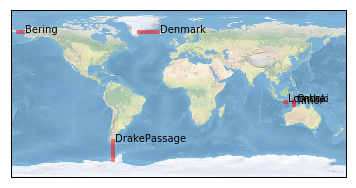

In [60]:
import cartopy.crs as ccrs

ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()

for straight, (xmin, xmax, ymin, ymax) in straights.items():

    plt.plot([xmin, xmax], [ymin, ymax],
            color='red', linewidth=4, alpha=0.5,
             transform=ccrs.Geodetic() )
   
    plt.annotate(xy=(xmin, ymin), xycoords='data',
                 xytext=(xmax+2, ymax),
                 s=straight,
               #  arrowprops=dict(facecolor='black', shrink=0.05),
                 transform=ccrs.Geodetic(),
                clip_on=True)

#ax.set_global()
#plt.annotate(xy=(0, 0), s='origin', transform=ccrs.Geodetic())
#plt.show()


In [111]:
expt = 'KDS75_UP'
transport = cc.get_nc_variable(expt, 'ocean.nc',
                               'tx_trans',
                               time_units = 'days since 2000')


In [ ]:
def calc_transport(expt, straight):
    """
    Calculate barotropic transport across a given 
     line of latitude or longitude.
    Designed for flow through straits.
    """
    
    print('Calculating {}:{} transport'.format(expt, straight))
    
    xmin, xmax, ymin, ymax = straights[straight]
    
    if xmin == xmax:
        op = lambda p: p.sel(yt_ocean=slice(ymin, ymax))\
                    .sel(yt_ocean=slice(ymin, ymax))\
                    .chunk({'time':1})\
                    .sum('st_ocean').sum('yt_ocean')
        transport_var = 'tx_trans'
                     
        transport = get_nc_variable(expt, 
                                'ocean.nc', 
                                'tx_trans',
                                op=op)

    elif 'yloc' in straight:

        xmin, xmax = straight['xmin'], straight['xmax']
        yloc = straight['yloc']
        
        op = lambda p: p.isel(yu_ocean=yloc)\
                        .isel(xt_ocean=slice(xmin, xmax))\
                        .chunk({'time':1})\
                        .sum('st_ocean').sum('xt_ocean')
                
        transport = get_nc_variable(expt, 'ocean.nc', 'ty_trans',
                                    chunks=None,
                                    op=op)
    else:
        raise ValueError('Transports are computed only along lines of either constant latitude or longitude')
    
    transport = transport.load()
       
    return transport

In [61]:
@memory.cache
def calc_transport(expt, straight):
    """
    Calculate barotropic transport across a given 
     line of latitude or longitude.
    Primarily designed for flow through straits.
    """
    
    print('Calculating {}:{} transport'.format(expt, straight['name']))
    
    if 'xloc' in straight:

        ymin, ymax = straight['ymin'], straight['ymax']
        xloc = straight['xloc']
        
        op = lambda p: p.isel(xu_ocean=xloc)\
                        .isel(yt_ocean=slice(ymin, ymax))\
                        .chunk({'time':1})\
                        .sum('st_ocean').sum('yt_ocean')
                     
        transport = get_nc_variable(expt, 'ocean.nc', 'tx_trans',
                                    chunks=None,
                                    op=op)

    elif 'yloc' in straight:

        xmin, xmax = straight['xmin'], straight['xmax']
        yloc = straight['yloc']
        
        op = lambda p: p.isel(yu_ocean=yloc)\
                        .isel(xt_ocean=slice(xmin, xmax))\
                        .chunk({'time':1})\
                        .sum('st_ocean').sum('xt_ocean')
                
        transport = get_nc_variable(expt, 'ocean.nc', 'ty_trans',
                                    chunks=None,
                                    op=op)
    else:
        raise ValueError('Transports are computed only along lines of either constant latitude or longitude')
    
    transport = transport.load()
       
    return transport

NameError: name 'memory' is not defined

When distributing a computing with dask, you should try and minimize the number of task while
keeping each task appropriate to a single work regarding memory usage.

/short/v45/jm0634/conda/envs/cosima/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


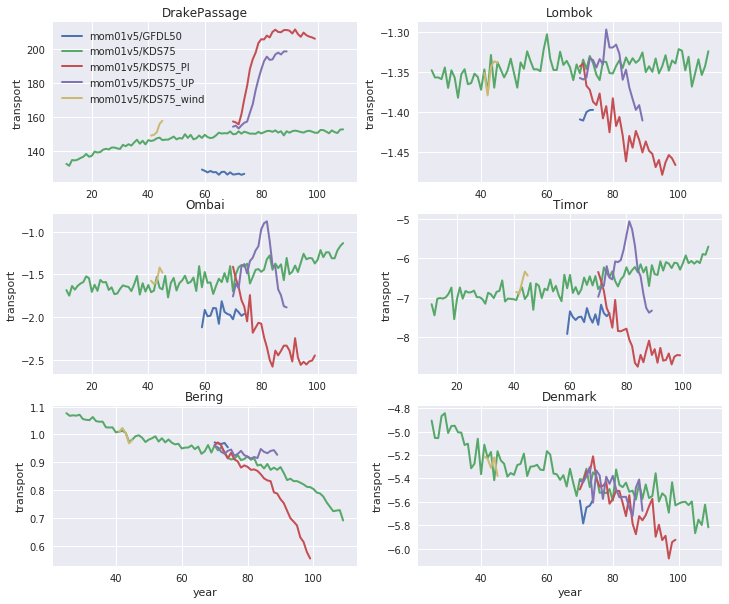

In [77]:
plt.figure(figsize=(12,10))

for expt in expts:
    if 'mom025' in expt:
        # need to change straights from grid coordinates to real word positions
        continue
        
    nplot = 0
    
    for straight in straights:
        nplot += 1
       
        transport = calc_transport(expt, straight)
        
        # see https://github.com/spencerahill/aospy/issues/98#issuecomment-256043833
        da = transport.to_dataset(name='transport')
                                
        periods = []
        for date in da['time']:
            raw_date = date.values.item()
            periods.append(pd.Period(year=raw_date.year, month=raw_date.month, 
                                     day=raw_date.day, freq='D'))
        da['time'] = pd.PeriodIndex(periods)
        da = da.groupby('time.year').mean('time')
        transport = da.transport
        
        plt.subplot(3, 2, nplot)
        transport.plot(label=expt, linewidth=2)
        plt.title( straight['name'])
        
plt.subplot(321)
plt.legend(loc='upper left')
#plt.ylabel('Transport (Sv)')
plt.xlabel('')
plt.subplot(322)
#plt.ylabel('')
plt.xlabel('')
plt.subplot(323)
#plt.ylabel('Transport (Sv)')
plt.xlabel('')
plt.subplot(324)
#plt.ylabel('')
plt.xlabel('')
plt.subplot(325)
#plt.ylabel('Transport (Sv)')
#plt.xlabel('Time')
plt.subplot(326)
#plt.ylabel('')
#plt.xlabel('Time')